# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código. De modo que si se consigue forzar el overfitting, entonces se puede congraciar que el modelo de difusión está bien implementado.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Dataset overfitting](#11-dataset-overfitting)

- [2. Modelo de Difusión](#2-modelo-de-difusión)
- [3.1. Resultados del overfitting](#3-resultados-del-overfitting)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import random
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-07-13 15:14:33.420846: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-13 15:14:33.451098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 15:14:34.674510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 15:14:34.678243: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = 200
TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

## 1. Dataset

- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


2024-07-13 15:14:35.512650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


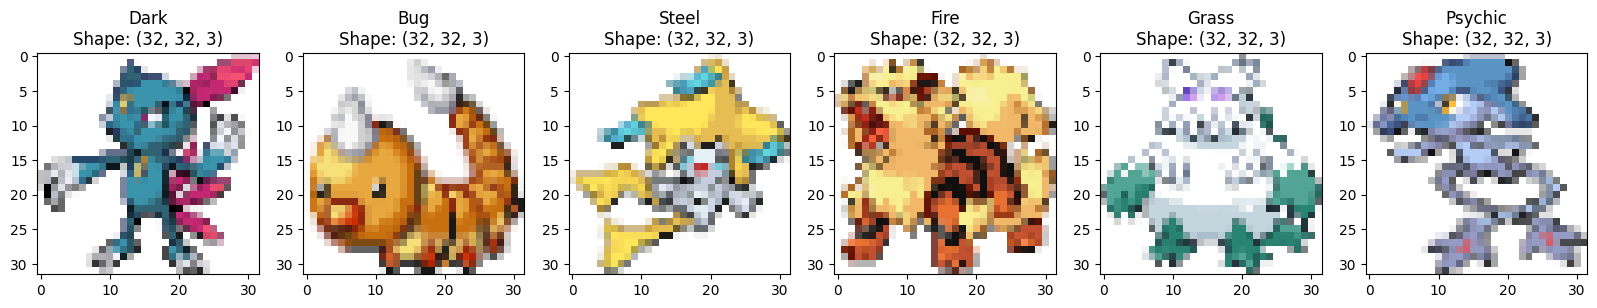

2024-07-13 15:14:36.434956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

### 1.1. Dataset overfitting

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(128, 32, 32, 3)
(128, 18)


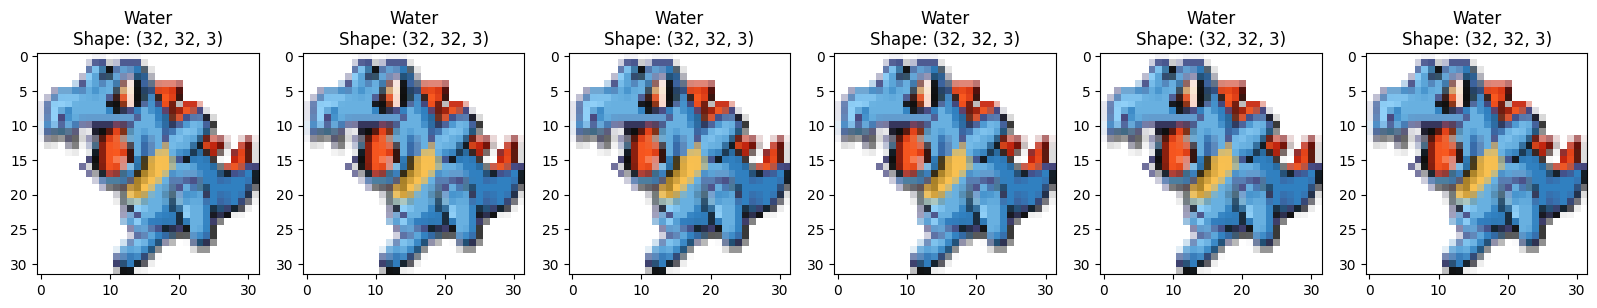

2024-07-13 15:15:56.928363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-13 15:15:56.929376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [49]:
# get one batch of the dataset
dataset_example = poke_dataset.take(len(poke_dataset))

# get one specific image of the batch
for img, label in dataset_example:
    random_index = random.randint(0, len(poke_dataset) - 1)
    img_example = img[random_index]
    label_example = label[random_index]
    break

# expand the items to the batch size
img_example = np.expand_dims(img_example, axis=0)
label_example = np.expand_dims(label_example, axis=0)

dataset_overfitting = tf.data.Dataset.from_tensor_slices((img_example, label_example))

n_images = len(poke_dataset) * BATCH_SIZE
dataset_overfitting = dataset_overfitting.repeat(n_images).batch(BATCH_SIZE)

for img, label in dataset_overfitting:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_overfitting.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_overfitting)

## 2. Modelo de Difusión

In [51]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, dropout_rate=0.1)
ema_u_net = build_unet(IMG_SIZE, NUM_CLASSES, dropout_rate=0.1) # EMA model for smoother training
ema_u_net.set_weights(u_net.get_weights()) # Initialize EMA model with the same weights

model = DiffusionModel(
    model=u_net,
    ema_model=ema_u_net,
    img_size=IMG_SIZE,
    num_classes=NUM_CLASSES,
    timesteps=TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    s=S,
    scheduler=SCHEDULER,
    ema=0.999
)

# Compile the model
# =====================================================================
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

Epoch 1/200


/home/pqlza/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma'

 1/31 ━━━━━━━━━━━━━━━━━━━━ 30:32 61s/step - mae: 1.2002 - loss: 2.2798

I0000 00:00:1720883845.216224 1051220 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1720883845.252235 1051220 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 113ms/step - mae: 0.8859 - loss: 1.2928
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.5321 - loss: 0.4782
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.4249 - loss: 0.3251
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.3855 - loss: 0.2761
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.3595 - loss: 0.2448
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.3322 - loss: 0.2113
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.3160 - loss: 0.1965
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.3036 - loss: 0.1841
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.2880 - loss: 0.1695
Epoch 10/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.2718 - loss: 0.1538
Epoch 11/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.2586 - loss: 0.1405
Epoch 12/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.2444 - loss: 0.1279
Epoch 13/200
31/31 ━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:39<00:00, 10.03it/s]


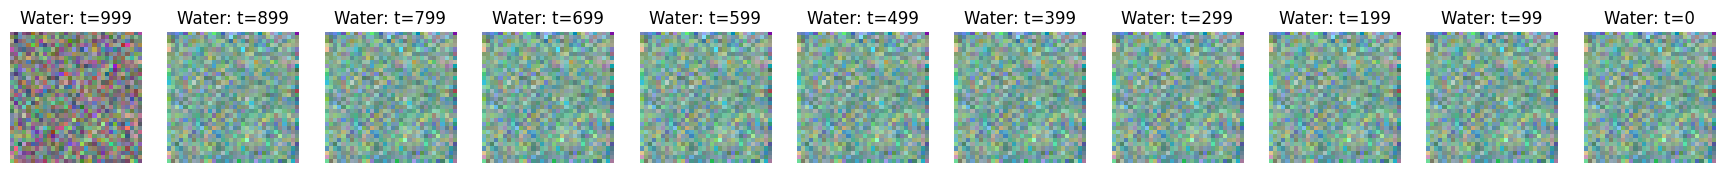

31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - mae: 0.1534 - loss: 0.0540 
Epoch 26/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.1521 - loss: 0.0534
Epoch 27/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1462 - loss: 0.0480
Epoch 28/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1411 - loss: 0.0451
Epoch 29/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1456 - loss: 0.0493
Epoch 30/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1372 - loss: 0.0430
Epoch 31/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1370 - loss: 0.0430
Epoch 32/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1354 - loss: 0.0424
Epoch 33/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1318 - loss: 0.0393
Epoch 34/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1310 - loss: 0.0391
Epoch 35/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1306 - loss: 0.0390
Epoch 36/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1264 - loss: 0.0368
Epoch 37/200
31/3

Sampling sprite...: 100%|██████████| 999/999 [01:40<00:00,  9.97it/s]


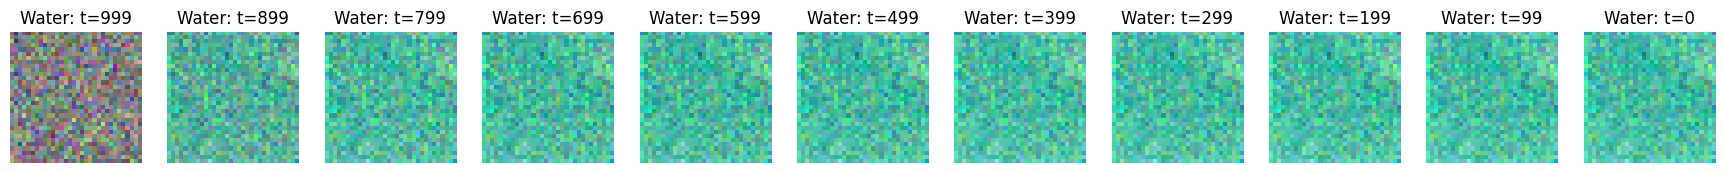

31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - mae: 0.1110 - loss: 0.0301 
Epoch 51/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.1093 - loss: 0.0282
Epoch 52/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1103 - loss: 0.0293
Epoch 53/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1078 - loss: 0.0279
Epoch 54/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1052 - loss: 0.0264
Epoch 55/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1076 - loss: 0.0286
Epoch 56/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1072 - loss: 0.0278
Epoch 57/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.1051 - loss: 0.0270
Epoch 58/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1039 - loss: 0.0269
Epoch 59/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1016 - loss: 0.0246
Epoch 60/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1009 - loss: 0.0245
Epoch 61/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.1018 - loss: 0.0255
Epoch 62/200
31/3

Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.47it/s]


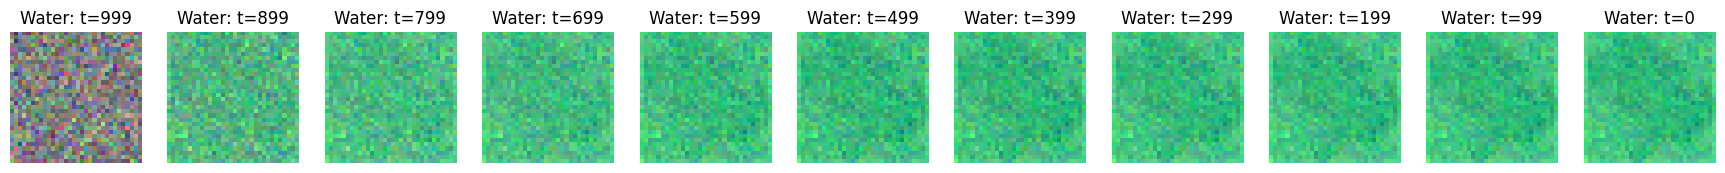

31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - mae: 0.0939 - loss: 0.0224 
Epoch 76/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0919 - loss: 0.0210
Epoch 77/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0885 - loss: 0.0189
Epoch 78/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0906 - loss: 0.0208
Epoch 79/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0876 - loss: 0.0187
Epoch 80/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0915 - loss: 0.0216
Epoch 81/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0877 - loss: 0.0193
Epoch 82/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0867 - loss: 0.0186
Epoch 83/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0868 - loss: 0.0189
Epoch 84/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - mae: 0.0874 - loss: 0.0193
Epoch 85/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0874 - loss: 0.0194
Epoch 86/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.0854 - loss: 0.0183
Epoch 87/200
31/3

Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.49it/s]


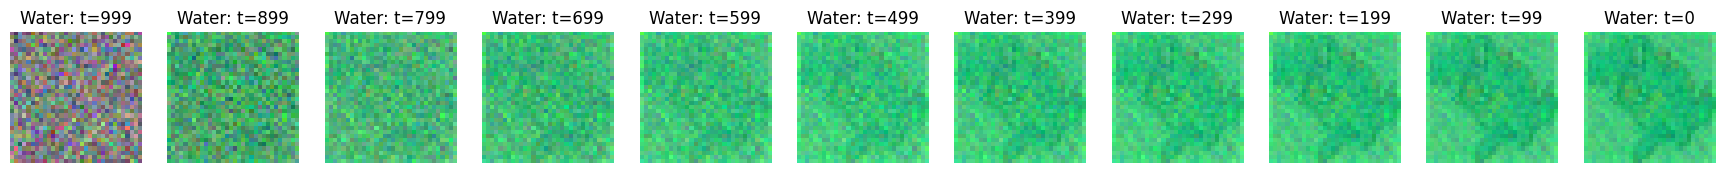

31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - mae: 0.0877 - loss: 0.0195 
Epoch 101/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0848 - loss: 0.0178
Epoch 102/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0784 - loss: 0.0150
Epoch 103/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0789 - loss: 0.0158
Epoch 104/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0786 - loss: 0.0160
Epoch 105/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0764 - loss: 0.0144
Epoch 106/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0780 - loss: 0.0159
Epoch 107/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0770 - loss: 0.0152
Epoch 108/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.0758 - loss: 0.0146
Epoch 109/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.0759 - loss: 0.0148
Epoch 110/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0778 - loss: 0.0159
Epoch 111/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0754 - loss: 0.0146
Epoch 

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.59it/s]


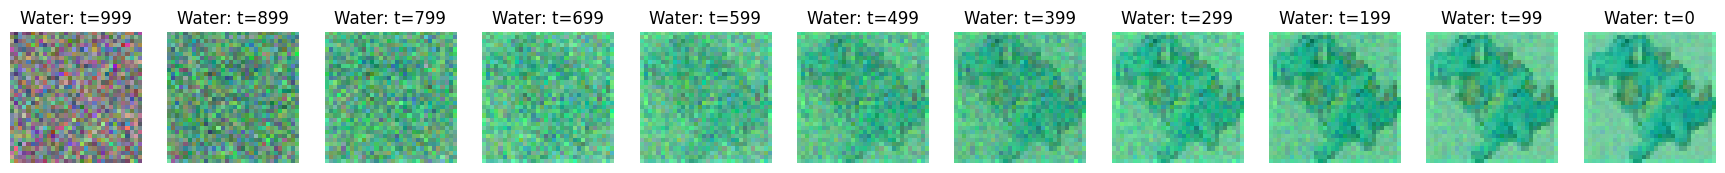

31/31 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.0730 - loss: 0.0146  
Epoch 126/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0697 - loss: 0.0120
Epoch 127/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0741 - loss: 0.0143
Epoch 128/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0732 - loss: 0.0141
Epoch 129/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0740 - loss: 0.0142
Epoch 130/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0698 - loss: 0.0124
Epoch 131/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0700 - loss: 0.0127
Epoch 132/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0703 - loss: 0.0131
Epoch 133/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0712 - loss: 0.0139
Epoch 134/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.0705 - loss: 0.0134
Epoch 135/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0724 - loss: 0.0140
Epoch 136/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.0701 - loss: 0.0132
Epoch 

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.66it/s]


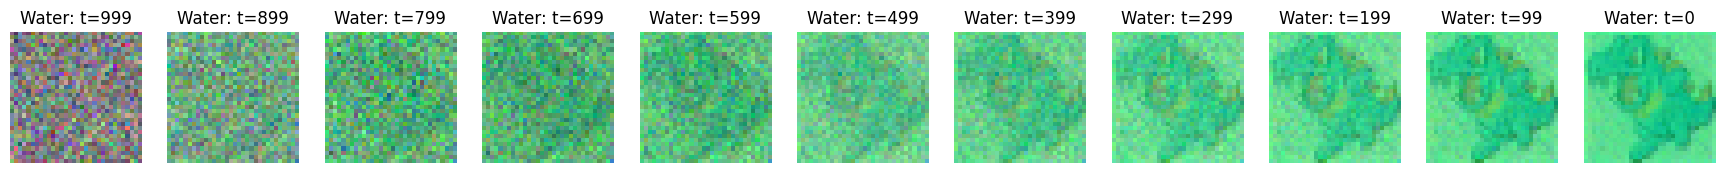

31/31 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.0663 - loss: 0.0116  
Epoch 151/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0700 - loss: 0.0134
Epoch 152/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0703 - loss: 0.0137
Epoch 153/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.0649 - loss: 0.0107
Epoch 154/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0655 - loss: 0.0113
Epoch 155/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.0653 - loss: 0.0114
Epoch 156/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0649 - loss: 0.0111
Epoch 157/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0671 - loss: 0.0133
Epoch 158/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - mae: 0.0661 - loss: 0.0112
Epoch 159/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - mae: 0.0637 - loss: 0.0108
Epoch 160/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0660 - loss: 0.0117
Epoch 161/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0680 - loss: 0.0125
Epoch 

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.72it/s]


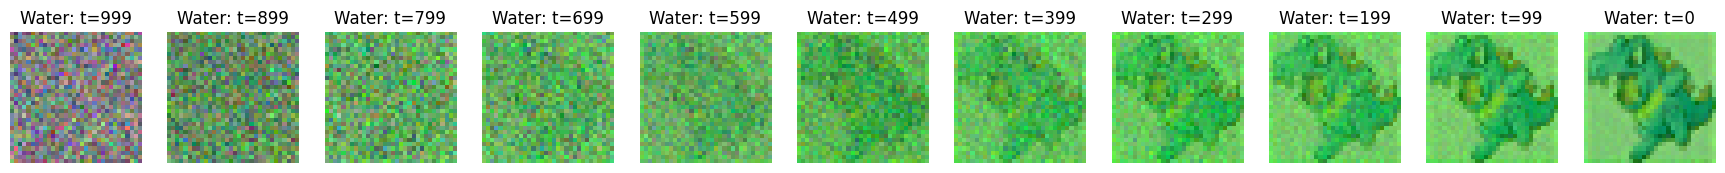

31/31 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.0624 - loss: 0.0103  
Epoch 176/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0602 - loss: 0.0093
Epoch 177/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0615 - loss: 0.0105
Epoch 178/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - mae: 0.0598 - loss: 0.0095
Epoch 179/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - mae: 0.0642 - loss: 0.0115
Epoch 180/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0596 - loss: 0.0096
Epoch 181/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0624 - loss: 0.0109
Epoch 182/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0615 - loss: 0.0110
Epoch 183/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0594 - loss: 0.0092
Epoch 184/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0625 - loss: 0.0107
Epoch 185/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0599 - loss: 0.0098
Epoch 186/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - mae: 0.0620 - loss: 0.0111
Epoch 

Sampling sprite...: 100%|██████████| 999/999 [01:39<00:00, 10.03it/s]


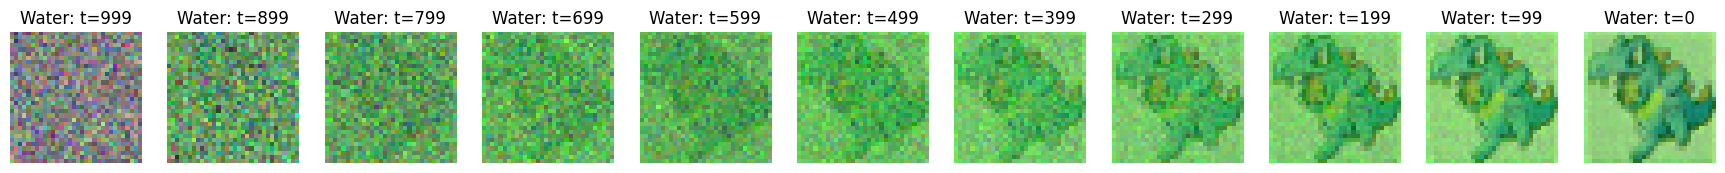

31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - mae: 0.0576 - loss: 0.0093 


In [52]:
# Train the model
# =====================================================================
diff_callback = DiffusionCallback(model, 25, onehot_to_string(label_example), save_interim=False)
history = model.fit(
    dataset_overfitting,
    epochs=EPOCHS,
    callbacks=[diff_callback],
)

## 3. Resultados del overfitting

Generating sample 1/1


Sampling sprite...: 100%|██████████| 999/999 [01:38<00:00, 10.16it/s]


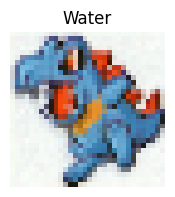

In [53]:
model.plot_samples(1, onehot_to_string(label_example))

Generating sample 1/6


Sampling sprite...: 100%|██████████| 999/999 [01:36<00:00, 10.35it/s]


Generating sample 2/6


Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.55it/s]


Generating sample 3/6


Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.69it/s]


Generating sample 4/6


Sampling sprite...: 100%|██████████| 999/999 [01:30<00:00, 11.03it/s]


Generating sample 5/6


Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.46it/s]


Generating sample 6/6


Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.45it/s]


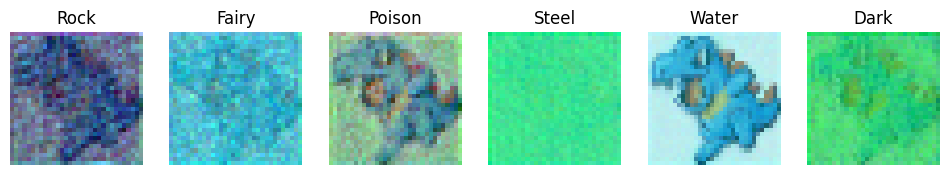

In [54]:
model.plot_samples(6)